# Market selection by using portfolio theory

In [82]:

import os,sys,matplotlib,pandas,numpy,scipy,dateutil
import pandas as pd
import numpy as np
from pylab import *
from datetime import datetime, timedelta
import time
from statsmodels.distributions.empirical_distribution import ECDF
import sqlite3
import itertools, random
import pickle
conn = None


## Reading price data.
Connect to database first, and the slurp the data for the given markets 

In [83]:
markets = [ {'type': 'g2.2xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'c3.xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'r3.large', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'm3.medium', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'd2.8xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'}
                     ]

In [84]:
def instance_to_MarketId(i) :
    """ The database table names or the file names  """
    osname = {'Linux':'Linux/UNIX'}
    return i['region']+i['AZ']+'-'+osname[i['OS']]+'-'+i['type']

def instance_string(i):
    return i['region']+i['AZ']+'-'+ i['OS']+'-'+i['type']

In [85]:
#Test the instance string functions
str(instance_string(markets[0]))

'us-east-1a-Linux-g2.2xlarge'

In [86]:
def init_db_connection() :
    global conn
    conn = sqlite3.connect('/home/prateeks/spot_prices_2015/aws.db')
    return 

init_db_connection();


In [87]:
print conn

In [88]:
def read_data_sqlite(instance , mktstring=None, months=['201503','201504','201505','201506','201507','201508'],pickle_data=True):
    """ Get the spot AND on-demand prices for a given instance over the months specified. 
        These 6 months are chosen to maximixe the data density, since other months have larger periods of missing data
    """
    global conn
    table_name_base='AKIAJXNAQH5WHJFPNCXA_' # '201503'
    if mktstring == None:
        mktstring = instance_to_MarketId(instance)
    output=[]
    ondem=[]
    ondemtable = 'on_demand_price'
    #Need to remove avail zone from mkt string argh!
   #TODO: function for converting to the on-demand string 
    ondem_mktstring = mktstring.replace('a-','-')
    ondem_mktstring = ondem_mktstring.replace('/UNIX','')
    q2 = 'SELECT SpotPrice FROM {} WHERE MarketId=\'{}\' ;'.format(ondemtable, ondem_mktstring)
    d2 = conn.execute(q2)
    ondem = d2.fetchall()

    for month in months :
        table_name = table_name_base+month
        query='SELECT Timestamp, SpotPrice FROM {} WHERE MarketId=\'{}\' ;'.format(table_name, mktstring)
        #print query
        d = conn.execute(query)
        output.extend(d.fetchall())
    if pickle_data is True :
        fname = instance_string(instance)+'.pickle'
        with open(fname, 'w') as f :
            pickle.dump((instance, output, ondem[0][0]), f)
    return output, ondem[0][0]


In [89]:
def get_spot_data(markets, from_pickle=False):
    """
    Markets is a list of market/instance objects. 
    Return [(mkt,on-demprice,[(t,spot-price)])]
    """
    global conn
    data = []
    
    if from_pickle is False:
        init_db_connection()
        #c3.xlarge seems volatile
        for i in markets :
            ts, ondem = read_data_sqlite(i)
            spot = [(time.mktime(dateutil.parser.parse(t).timetuple()), float(f)) for (t,f) in ts]
            nspot = np.array(spot)
            data.append((i, float(ondem), nspot))
    else : 
        #Read all the pickle files from the directory and call get_pickled_data
        for file in os.listdir('.'):
            if file.endswith(".pickle") :
                with open(file,'r') as f:
                    (i, ts, ondem) = get_picked_data(f)
                    spot = [(time.mktime(dateutil.parser.parse(t).timetuple()), float(f)) for (t,f) in ts]
                    nspot = np.array(spot)
                    data.append((i, float(ondem), nspot))

    return data


In [90]:
def get_picked_data(f):
    """ Get pickled data from a file instead of the database. 
        Return (instance, ts, ondem) tuple. """
    (instance, ts, ondem) = pickle.load(f)
    return (instance, ts, ondem)
    

In [91]:
ls

all-cdf.py               time_series_1.ipynb
Bidding_1.ipynb          Untitled0-Copy0_1.ipynb
Bidding_2.ipynb          Untitled0.ipynb
Correlation-Copy0.ipynb  Untitled1.ipynb
Correlation.ipynb        Untitled2.ipynb
cvtest.py                us-east-1a-Linux-c3.xlarge.pickle
ft-mechanisms.py         us-east-1a-Linux-d2.8xlarge.pickle
overyears.py             us-east-1a-Linux-g2.2xlarge.pickle
parr_ex_price.py         us-east-1a-Linux-m3.medium.pickle
README.md                us-east-1a-Linux-r3.large.pickle
spike_correlation.ipynb  var-risk-Copy1.ipynb
spot_analysis.py         var-risk.ipynb
spotfail.py*             years.ipynb
testr.R


In [92]:
data = get_spot_data(markets, from_pickle=True)

({'AZ': 'a', 'OS': 'Linux', 'region': 'us-east-1', 'type': 'r3.large'},
 0.175,
 array([[  1.42611062e+09,   2.19000000e-02],
        [  1.42611100e+09,   1.50000000e+00],
        [  1.42611136e+09,   1.70000000e-02],
        ..., 
        [  1.44108322e+09,   2.27000000e-02],
        [  1.44108339e+09,   2.26000000e-02],
        [  1.44108355e+09,   2.28000000e-02]]))

In [102]:
def get_prices_only(d, normalized=False, interpolate=False):
    """ For a given 3-tuple, return an array of prices. Strip the timestamps
    """
    ondem_price = d[1]
    spot_prices = d[2][:,1]
    if interpolate :
        spot_prices = interpolate_prices(d)
    if normalized:
        return spot_prices/ondem_price  #time, price
    else :
        return spot_prices
    
#normalized_price(data[0])

In [103]:
def interpolate_prices(d, duration='5min'):
    """ Large gaps exist in many traces. Do some interpolation to obtain a uniform trace
    """
    spot_prices = d[2][:,1]
    timestamps = d[2][:,0]
    tdindex = pd.to_datetime(timestamps, unit='s') #Unit=s makes it parse the unix timestamps
    ms = pd.Series(spot_prices, index=tdindex)
    mdf = pd.DataFrame(ms,columns=["price"] )
    
    mdf = mdf.resample(duration,fill_method='pad')
    print mdf.describe()
    print mdf
    return mdf['price']
    
    

    

In [105]:
def bid_transform(d,interpolate=False):
    """Given a bid, execute some transformation over the prices."""
    ondem_price = d[1]
    spot_prices = d[2][:,1]
    if interpolate:
        spot_prices = interpolate_prices(d)
    
    maxprice = 10*ondem_price
    bid = ondem_price 
    spot_prices[spot_prices >= bid] = maxprice #Amplify the price spike
    spot_prices = maxprice - spot_prices  #Price => Profits transformation
    #Not sure we want to normalize this to the on-demand price? Hmm...
    #Normalizing by 10*on-demand price yields returns which are monotonically *DECREASING* with risk
    #We want increasing returns with increasing risk, so turn off the normalization
    return spot_prices
    


In [106]:
prices = get_prices_only(data[0])

In [107]:
def get_transformed_prices(d, interpolate=True, transform="bid"):
    td = [] #List of transformed prices
    instances = []

    for di in d:
        if transform=="bid":
            td.append(bid_transform(di,interpolate))
        elif transform=="plain":
            td.append(get_prices_only(di,interpolate))
        instances.append(di[0])
    min_length = min([len(a) for a in td])

    print min_length
    return (instances, np.vstack([a[:min_length] for a in td]) )


In [108]:
(instances, dt) = get_transformed_prices(data, transform="bid")
import scipy.stats

              price
count  49910.000000
mean       0.291593
std        0.903105
min        0.064100
25%        0.065000
50%        0.072100
75%        0.095900
max        6.500000
                       price
2015-03-11 21:50:00  0.06520
2015-03-11 21:55:00  0.06500
2015-03-11 22:00:00  0.06500
2015-03-11 22:05:00  0.06510
2015-03-11 22:10:00  0.06510
2015-03-11 22:15:00  0.06510
2015-03-11 22:20:00  0.06530
2015-03-11 22:25:00  0.06530
2015-03-11 22:30:00  0.06550
2015-03-11 22:35:00  0.06550
2015-03-11 22:40:00  0.06550
2015-03-11 22:45:00  0.06550
2015-03-11 22:50:00  0.06550
2015-03-11 22:55:00  0.06550
2015-03-11 23:00:00  0.06550
2015-03-11 23:05:00  0.06550
2015-03-11 23:10:00  0.06550
2015-03-11 23:15:00  0.06540
2015-03-11 23:20:00  0.06510
2015-03-11 23:25:00  0.06500
2015-03-11 23:30:00  0.06510
2015-03-11 23:35:00  0.06510
2015-03-11 23:40:00  0.06510
2015-03-11 23:45:00  0.06500
2015-03-11 23:50:00  0.06500
2015-03-11 23:55:00  0.06510
2015-03-12 00:00:00  0.06510
2015-03-

In [109]:
scipy.stats.describe(data[2][2][:,1])

DescribeResult(nobs=18661, minmax=(0.016, 1.55), mean=0.046969262097422422, variance=0.028767818682140355, skewness=8.08125609209537, kurtosis=65.67889934855386)

## Portfolio construction starts here
So far we have read in the spot prices, applied the transforms, and computed the covariance matrix. Now its time for the actual portfolio creation.


In [110]:
import cvxopt as opt
from cvxopt import blas, solvers
%matplotlib inline

In [111]:
solvers.options['show_progress'] = False

In [112]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [113]:
num_mkts = len(instances)

In [114]:
print num_mkts

5


In [115]:
def eval_portfolio(dt):
    p = np.asmatrix(np.mean(dt,axis=1))
    w = np.asmatrix(rand_weights(dt.shape[0]))
    C = np.asmatrix(np.cov(dt))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    print mu, sigma
    
    return mu, sigma

In [116]:
n_portfolios = 50
means, stds = np.column_stack([
    eval_portfolio(dt) 
    for _ in xrange(n_portfolios)
])


[[ 10.9710709]] [[ 1.99017429]]
[[ 6.13276455]] [[ 0.80405037]]
[[ 16.11629904]] [[ 2.80525402]]
[[ 10.48102004]] [[ 1.57979013]]
[[ 6.81084567]] [[ 1.24253173]]
[[ 11.51124446]] [[ 1.97310057]]
[[ 9.2796832]] [[ 1.59812799]]
[[ 7.79955259]] [[ 1.18085892]]
[[ 6.63511906]] [[ 1.09968996]]
[[ 7.66715475]] [[ 1.37663376]]
[[ 12.41186005]] [[ 2.18543201]]
[[ 10.61177]] [[ 1.83735337]]
[[ 22.47393372]] [[ 4.05005639]]
[[ 4.77938908]] [[ 0.56059199]]
[[ 22.28731291]] [[ 4.05617204]]
[[ 11.29086006]] [[ 1.86716507]]
[[ 19.18855313]] [[ 3.5449082]]
[[ 23.36333286]] [[ 4.25004511]]
[[ 20.27651381]] [[ 3.79132902]]
[[ 10.34862038]] [[ 1.69348573]]
[[ 4.30329836]] [[ 0.49020699]]
[[ 11.98807028]] [[ 2.14023267]]
[[ 6.33688781]] [[ 0.8405042]]
[[ 6.67623352]] [[ 1.01062367]]
[[ 19.45875223]] [[ 3.36529807]]
[[ 3.34086414]] [[ 0.41757907]]
[[ 13.22446502]] [[ 2.21882841]]
[[ 14.93558747]] [[ 2.54052581]]
[[ 14.15498911]] [[ 2.49504174]]
[[ 6.83433687]] [[ 1.01412335]]
[[ 18.59938658]] [[ 3.5699583

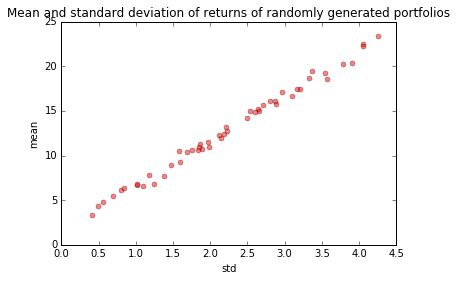

In [117]:
plt.plot(stds, means, 'o', markersize=5, color='r', alpha=0.5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')


In [118]:
def optimal_portfolio(returns):
    n = len(returns)
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    N = 10
    mus = [3.5**(8.0 * t/N - 1.0) for t in range(N)]
    #mus = [0.05+(0.05*t) for t in range(150)]
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    #returns = np.asmatrix(returns)   
    returns = opt.matrix(returns)
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    print "S, Covariance: ", S.size, S
    print "Returns: ", returns.size
    print "pbar: ", pbar.size, pbar
    print "G: ", G.size
    print "h: ", h.size
    print "A: ", A.size
    print "b: ", b.size
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios=[]
    for mu in mus:
        try:
            result = solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
            #Result is presumably the weights for a given mu
            portfolios.append(result)
        except :
            print "BAD MU ", mu
            pass
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    gradients = np.gradient(returns)
    print "PORTFOLIOS "
    for p,mu,r,grad, risk in zip(portfolios,mus,returns,gradients,risks):
        print mu, r, grad, risk, p.T
    print "POLYNOMIAL ", m1
    mu_star = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = np.zeros(n)
    try:
        wt = solvers.qp(opt.matrix(mu_star * S), -pbar, G, h, A, b)['x']
    except:
        print "NOT ABLE TO CALCULATE WEIGHT"
    return np.asarray(wt), returns, risks

In [119]:
weights, returns, risks = optimal_portfolio(dt)

S, Covariance:  (5, 5) [ 8.50e-01 -1.59e-03  8.10e-03 -2.26e-01 -3.20e-02]
[-1.59e-03  7.78e-01 -1.02e-02  3.10e-01  1.16e-01]
[ 8.10e-03 -1.02e-02  3.31e-01  8.65e-01 -2.39e-04]
[-2.26e-01  3.10e-01  8.65e-01  1.06e+02  3.24e-01]
[-3.20e-02  1.16e-01 -2.39e-04  3.24e-01  1.01e-01]

Returns:  (5, 44273)
pbar:  (5, 1) [ 6.28e+00]
[ 1.56e+00]
[ 1.51e+00]
[ 5.24e+01]
[ 2.45e-01]

G:  (5, 5)
h:  (5, 1)
A:  (1, 5)
b:  (1, 1)
PORTFOLIOS 
0.285714285714 52.4330787198 -20.2475400102 10.3079337449 [-1.25e-09 -6.55e-09 -6.57e-09  1.00e+00 -6.70e-09]

0.778370541551 32.1855387096 -18.175808212 5.79030130426 [ 4.39e-01  2.09e-09  3.90e-09  5.61e-01  2.26e-09]

2.12051244984 16.0814622958 -11.0076794608 2.2899103312 [ 7.88e-01  4.87e-09  3.84e-09  2.12e-01  3.48e-09]

5.77690548382 10.170179788 -5.45616263584 1.19698066371 [ 9.16e-01  7.52e-07  7.18e-08  8.43e-02  6.13e-09]

15.7380056748 5.16913702407 -3.84011487247 0.578445062283 [ 4.89e-01  1.04e-01  2.22e-01  2.99e-02  1.56e-01]

42.875 2.48995

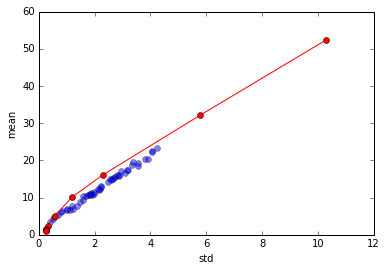

In [120]:
plt.plot(stds, means, 'o',alpha=0.5)
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'r-o')

In [12]:
def my_covariance(x,y):
    """
    This yields similiar results to
    pd.Series(x).cov(pd.Series(y)) """
    xbar = x.mean()
    ybar = y.mean()
    x = x-xbar
    y = y-ybar
    n = min(x.shape[0], y.shape[0])
    x = x[:n-1]
    y = y[:n-1]
    cov = (x*y)
    cov = np.sum(cov)/(n-1)
    print cov
    return cov


In [114]:
print dt

[[ -6.4348  -6.435   -6.4349 ...,  -6.4347  -6.4351  -6.4354]
 [ -2.0676  -2.0679  -2.0676 ...,  -2.0679  -2.0654  -2.0679]
 [ -1.7281   0.      -1.733  ...,  -1.7318  -1.7313  -1.7331]
 [-54.64   -54.6365 -54.6361 ..., -54.6354 -54.6348 -54.6354]
 [  0.       0.       0.     ...,  -0.653   -0.653   -0.653 ]]


In [13]:
my_covariance(x,y)

-8.02333628098e-05


-8.0233362809846391e-05

In [14]:
pd.Series(x).cov(pd.Series(y))

-8.0003161504696132e-05

In [16]:

d0=data[0]
d1=data[1]
print d0

({'OS': 'Linux', 'region': 'us-east-1', 'AZ': 'a', 'type': 'g2.2xlarge'}, 0.65, array([[  1.42611080e+09,   6.52000000e-02],
       [  1.42611117e+09,   6.50000000e-02],
       [  1.42611153e+09,   6.51000000e-02],
       ..., 
       [  1.44108320e+09,   1.25300000e-01],
       [  1.44108337e+09,   1.18500000e-01],
       [  1.44108353e+09,   1.14200000e-01]]))


In [17]:
s0 = pd.Series(d0[2][:,1], index=d0[2][:,0])